In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore") 
%matplotlib inline

pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv("../UncontrollableFactors-AprilData.csv")
data.columns

Index(['FacilityCode', 'facility_name', 'Clusters', 'Office Class',
       'FacilityOpeningDate', 'Current Working Year', '% AfricanAmerican',
       '% Hispanic', '% Uninsured', 'Median Normalised Income',
       'External comp Within 20 Miles', 'High School Graduates (5-7-10m)',
       'NPA Benchmarks', 'Fast Cas. Mexican Burger (.25m)',
       'Shop. Center GLA (1.5m)', 'Big Box Retailers (1.5m)',
       'Dental Chains (1m)', 'Delta Dental per 10K (10m)', '% Medicaid (10m)',
       'Years in DMA', 'Office Sq.Ft', 'Internal Competition',
       'TotalRevenuePerHour', 'EBITDAPerHour'],
      dtype='object')

In [3]:
data.drop(['FacilityCode', 'facility_name', 'Clusters', 'FacilityOpeningDate', 'EBITDAPerHour'], axis=1, inplace=True)

In [4]:
data['High School Graduates (5-7-10m)'] = data['High School Graduates (5-7-10m)'].str.replace('%','').astype(np.float64)
data['% Medicaid (10m)'] = data['% Medicaid (10m)'].str.replace('%','').astype(np.float64)
data['TotalRevenuePerHour'] = data['TotalRevenuePerHour'].str.replace('$', '').astype(np.int64)
# data['EBITDAPerHour'] = data['EBITDAPerHour'].str.replace('$', '').astype(np.int64)
data['% Hispanic'] = np.where(data['% Hispanic'] > 1, (data['% Hispanic']/100).round(2), data['% Hispanic'])

In [5]:
cols = ['% AfricanAmerican', '% Hispanic', '% Uninsured']
data[cols] = data[cols].apply(lambda x : x*100)

In [6]:
data['Office Sq.Ft'].fillna(data['Office Sq.Ft'].median(), inplace=True)
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [7]:
data['Shop. Center GLA (1.5m) ($100K)'] = (data['Shop. Center GLA (1.5m)']/100000).round(2)
data['Median Normalised Income ($10K)'] = (data['Median Normalised Income']/10000).round(2)
data['Office Sq.Ft (1K)'] = (data['Office Sq.Ft']/1000).round(2)
data['Avg. External comp Within 1 Mile'] = (data['External comp Within 20 Miles']/20).round(2)

data.drop(['Shop. Center GLA (1.5m)', 'Median Normalised Income', 'Office Sq.Ft', 'External comp Within 20 Miles'], axis=1, inplace=True)

In [8]:
# Capping att 99-percentile
data.iloc[:,1:] = np.where(data.iloc[:,1:]>data.iloc[:,1:].quantile(0.99),
                         data.iloc[:,1:].quantile(0.99),
                         data.iloc[:,1:])

### K-ProtoType (without scaling)

In [9]:
df = data.drop('TotalRevenuePerHour', axis=1).copy()

In [10]:
# Convert dataframe to matrix
dfMatrix = df.to_numpy()

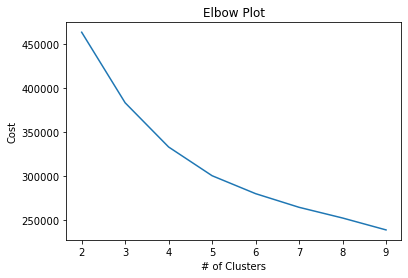

,# of Clusters,silhouette_score
0,2,0.28
1,3,0.26
2,4,0.27
3,5,0.18
4,6,0.17
5,7,0.17
6,8,0.16
7,9,0.17


In [11]:
# Choose optimal K using Elbow method
cost = []
scores = []

for cluster in range(2, 10):
    kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 42)
    kprototype.fit_predict(dfMatrix, categorical = [0])
    cost.append(kprototype.cost_)
    scores.append(silhouette_score(dfMatrix[:,1:], kprototype.labels_))
    
sns.lineplot(range(2,10), cost)
plt.xlabel("# of Clusters")
plt.ylabel("Cost")
plt.title("Elbow Plot")
plt.show()

# Silhouette scores for different k values
table = pd.DataFrame({'# of Clusters':range(2,10), 'silhouette_score':['%.2f' % x for x in scores]})
table

In [12]:
# Fitting K-prototype to the dataset
kprototype = KPrototypes(n_clusters = 5, init = 'Huang', random_state = 42, n_jobs = -2, gamma=1.5, max_iter=500)
y_hat = kprototype.fit_predict(dfMatrix, categorical = [0])

In [13]:
df_clusters = df.copy()
df_clusters['Cluster_ID'] = y_hat
df_clusters['TotalRevenuePerHour'] = data['TotalRevenuePerHour']
# df_clusters = pd.concat([df_clusters, data[['TotalRevenuePerHour', 'EBITDAPerHour']]], axis = 1)
df_clusters['Cluster_ID'].value_counts()

3    306
2    291
1    142
4    104
0     48
Name: Cluster_ID, dtype: int64

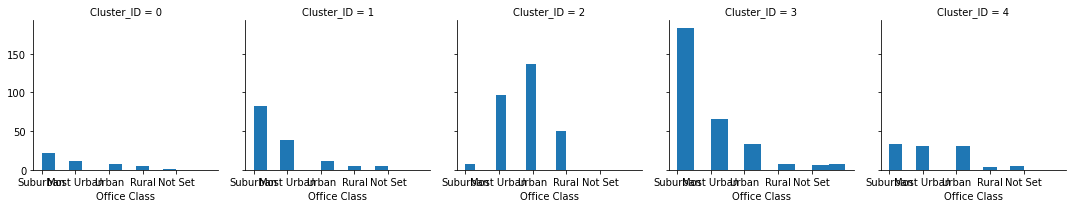

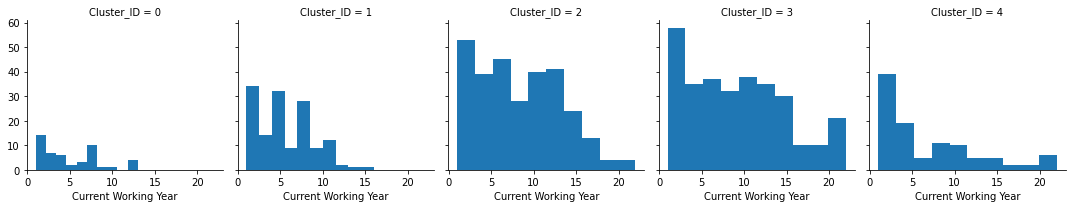

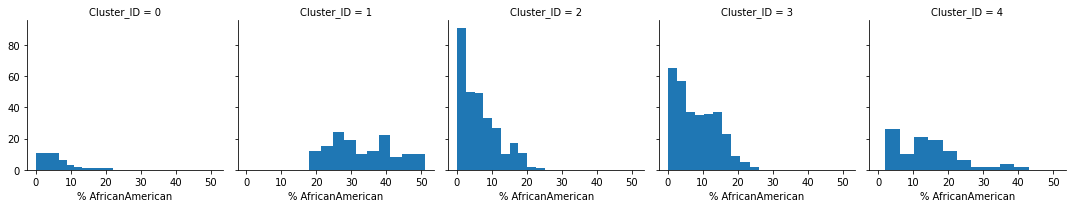

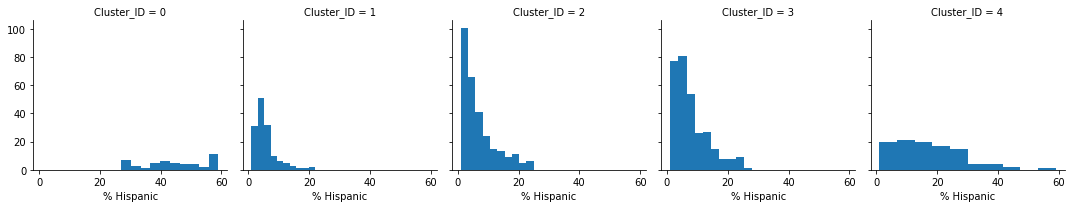

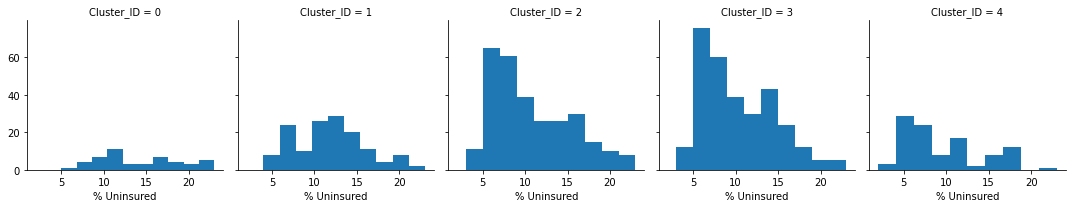

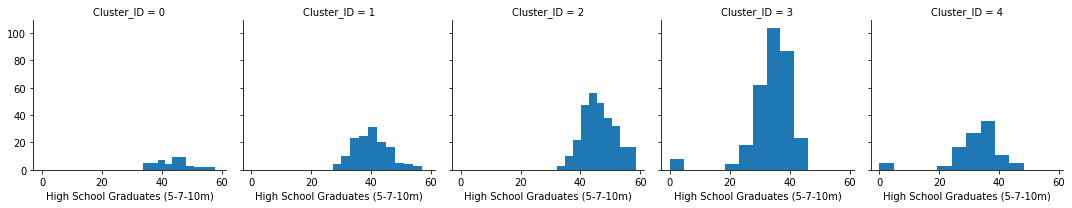

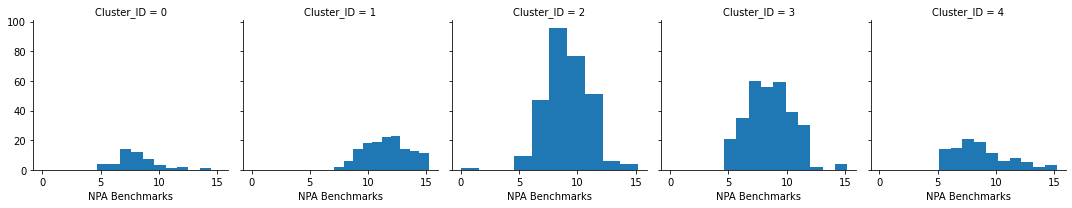

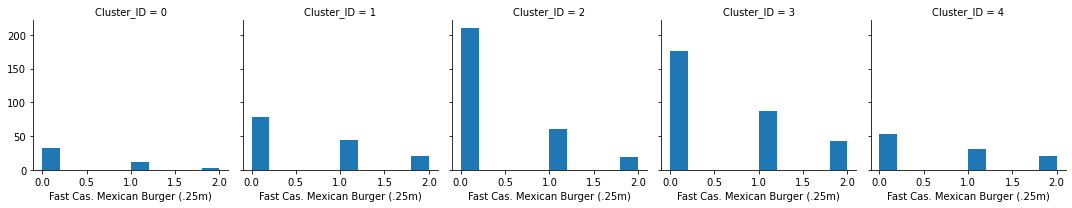

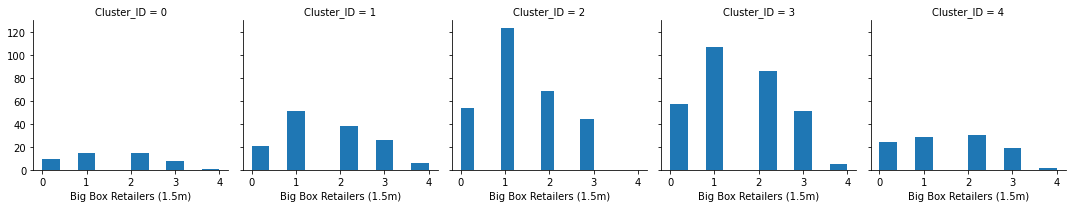

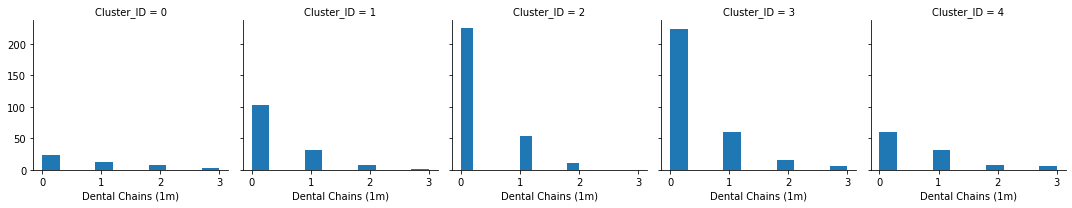

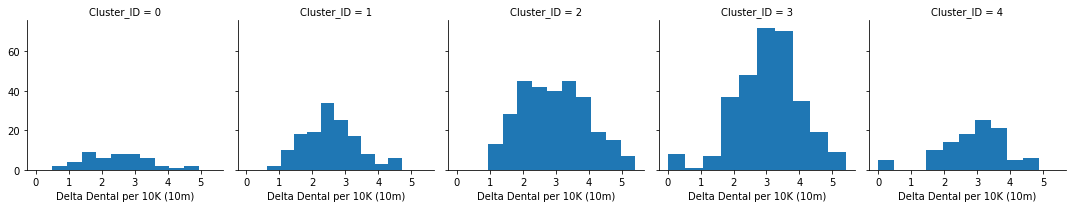

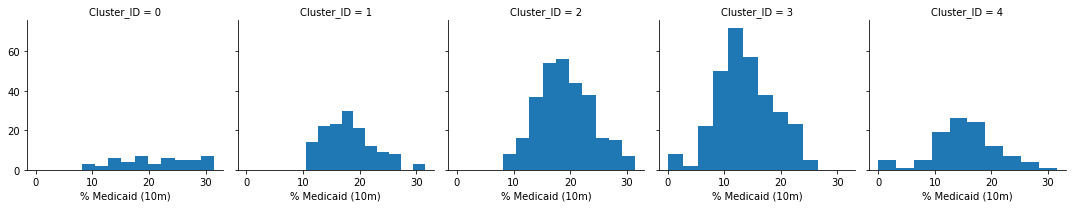

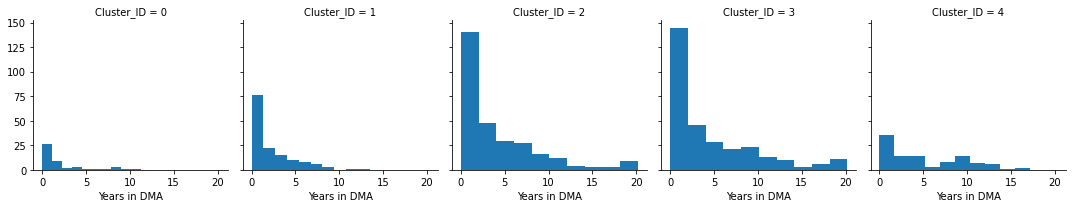

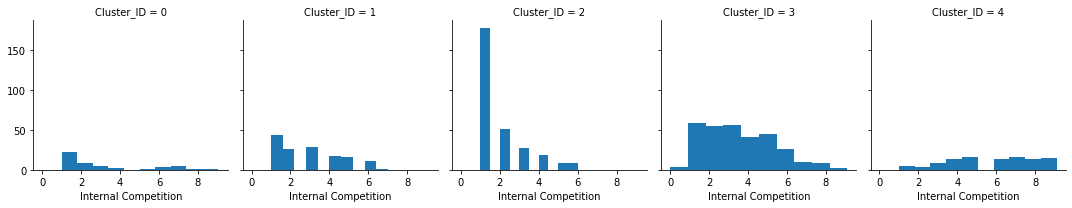

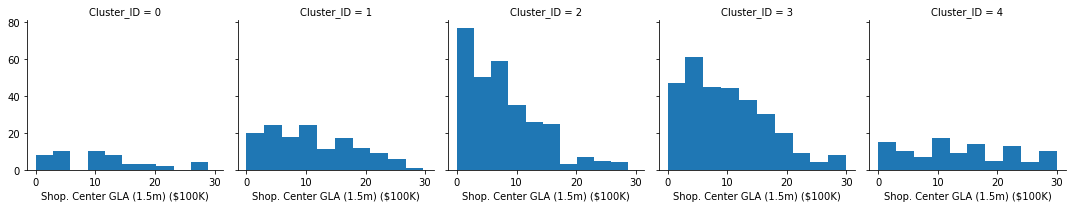

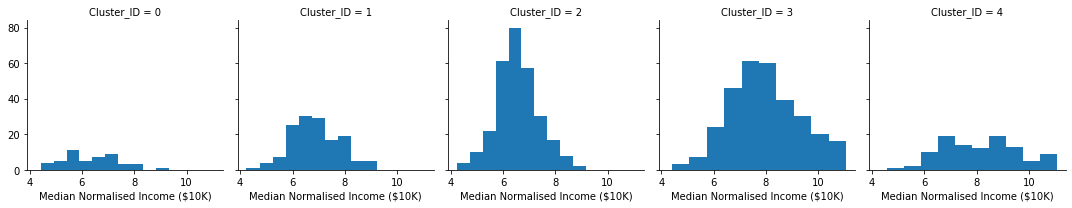

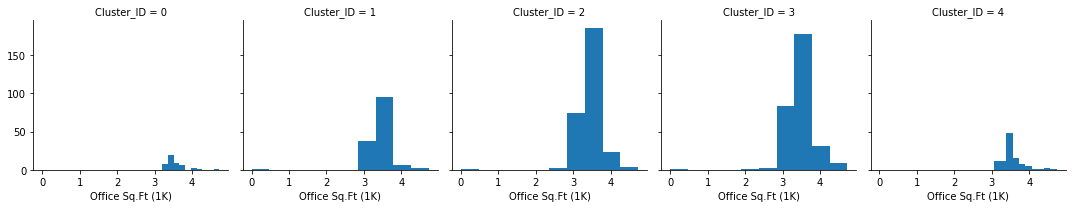

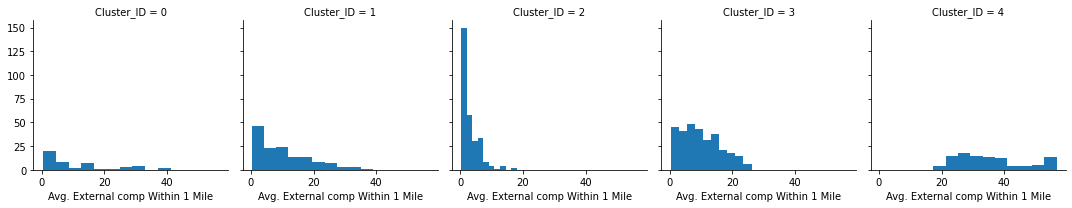

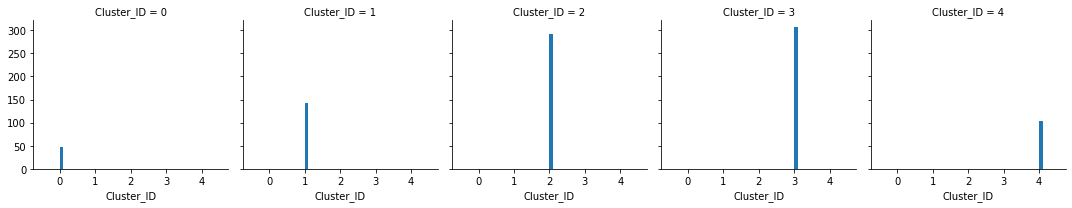

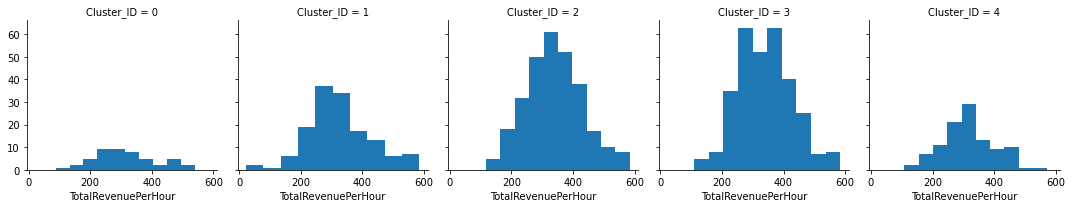

In [14]:
# sns.pairplot(df_clusters, hue='Cluster_ID', palette='dark')
for c in df_clusters:
    grid = sns.FacetGrid(df_clusters, col='Cluster_ID')
    grid.map(plt.hist, c)

### K-ProtoType (manual scaling + normalising)

In [15]:
scaler = MinMaxScaler()
cols = df.columns.to_list()[1:]

df_scaled = df.copy()
df_scaled[cols] = scaler.fit_transform(df_scaled[cols])
df_scaled

,Office Class,Current Working Year,% AfricanAmerican,% Hispanic,% Uninsured,High School Graduates (5-7-10m),NPA Benchmarks,Fast Cas. Mexican Burger (.25m),Big Box Retailers (1.5m),Dental Chains (1m),Delta Dental per 10K (10m),% Medicaid (10m),Years in DMA,Internal Competition,Shop. Center GLA (1.5m) ($100K),Median Normalised Income ($10K),Office Sq.Ft (1K),Avg. External comp Within 1 Mile
0,Suburban,1.000000,0.294118,0.327586,0.142857,0.658683,0.506579,0.0,0.25,0.000000,0.709017,0.694577,0.000000,0.769231,0.594439,0.499927,0.793147,0.405907
1,Suburban,1.000000,0.137255,0.293103,0.095238,0.744226,0.493421,0.0,0.75,0.000000,0.342404,0.704091,0.000000,0.769231,0.299055,0.356253,0.846024,0.255571
2,Urban,1.000000,0.039216,0.051724,0.095238,0.757913,0.447368,0.5,0.00,0.000000,0.478313,0.694577,0.000000,0.659341,0.312072,0.442750,0.835448,0.252034
3,Most Urban,1.000000,0.294118,0.310345,0.476190,0.566296,0.335526,0.0,0.00,0.000000,0.690954,0.618459,0.466834,0.439560,0.000000,0.747691,0.780457,0.396180
4,Suburban,0.857143,0.137255,0.224138,0.476190,0.516681,0.302632,0.0,0.00,0.000000,0.761687,0.313987,0.576326,0.329670,0.000000,1.000000,0.664129,0.412982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,Rural,0.428571,0.196078,0.224138,0.238095,0.704876,0.565789,0.0,0.25,0.333333,0.300148,0.558199,0.113829,0.439560,0.246320,0.545375,0.676819,0.173329
887,Rural,0.428571,0.176471,0.051724,0.571429,0.720274,0.486842,0.0,0.00,0.000000,0.722310,0.551855,0.043634,0.219780,0.060746,0.536578,0.676819,0.107004
888,Most Urban,0.428571,0.117647,0.637931,0.476190,0.653550,0.440789,1.0,0.50,0.333333,0.582871,0.751665,0.146080,0.989011,0.393845,0.281484,0.708545,1.000000
889,Suburban,0.428571,0.235294,0.241379,0.190476,0.698033,0.684211,0.0,0.25,0.000000,0.361104,0.637488,0.131852,0.439560,0.490304,0.425158,0.697970,0.118500


In [16]:
# Convert dataframe to matrix
dfMatrix = df_scaled.to_numpy()

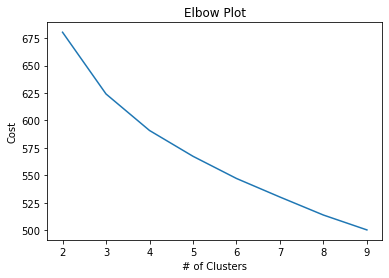

,# of Clusters,silhouette_score
0,2,0.15
1,3,0.08
2,4,0.08
3,5,0.09
4,6,0.09
5,7,0.09
6,8,0.08
7,9,0.09


In [17]:
# Choose optimal K using Elbow method
cost = []
scores = []

for cluster in range(2, 10):
    kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 42)
    kprototype.fit_predict(dfMatrix, categorical = [0])
    cost.append(kprototype.cost_)
    scores.append(silhouette_score(dfMatrix[:,1:], kprototype.labels_))
    
sns.lineplot(range(2,10), cost)
plt.xlabel("# of Clusters")
plt.ylabel("Cost")
plt.title("Elbow Plot")
plt.show()

# Silhouette scores for different k values
table = pd.DataFrame({'# of Clusters':range(2,10), 'silhouette_score':['%.2f' % x for x in scores]})
table

In [18]:
# Fitting K-prototype to the dataset
kprototype = KPrototypes(n_clusters = 5, init = 'Huang', random_state = 42, n_jobs = -2, gamma=1.5, max_iter=500)
y_hat = kprototype.fit_predict(dfMatrix, categorical = [0])

In [19]:
df_scaled_clusters = df.copy()
df_scaled_clusters['Cluster_ID'] = y_hat
df_scaled_clusters['TotalRevenuePerHour'] = data['TotalRevenuePerHour']
df_scaled_clusters['Cluster_ID'].value_counts()

3    419
2    250
1     95
4     69
0     58
Name: Cluster_ID, dtype: int64

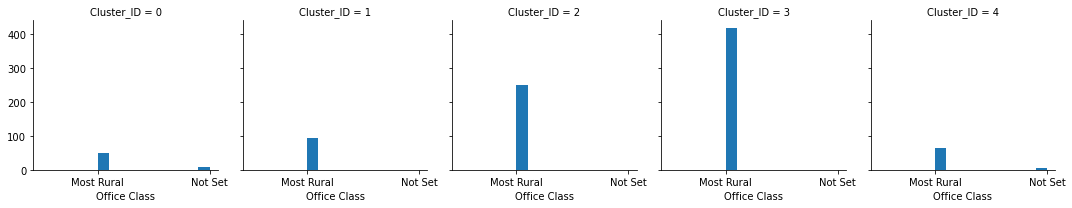

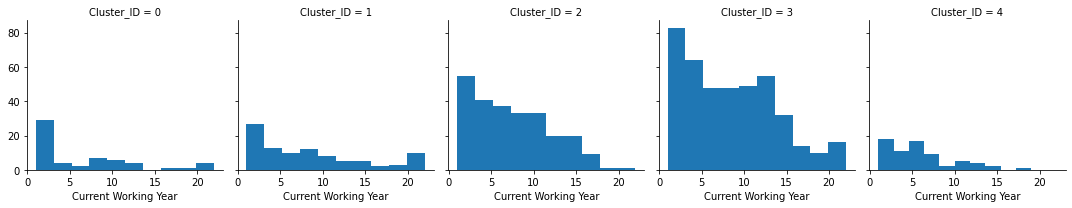

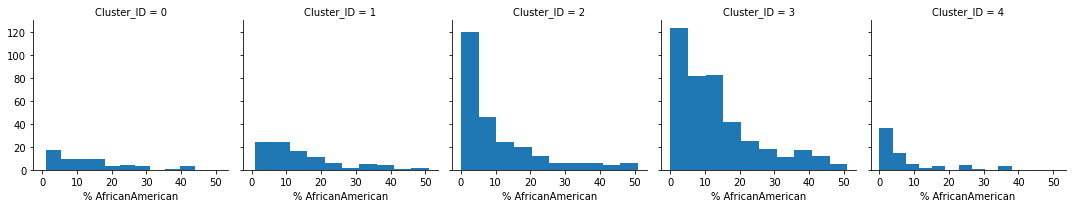

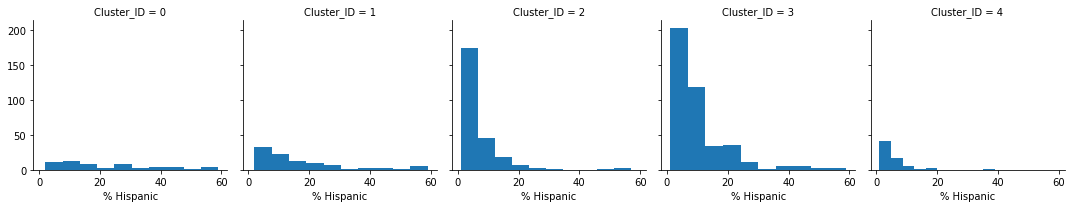

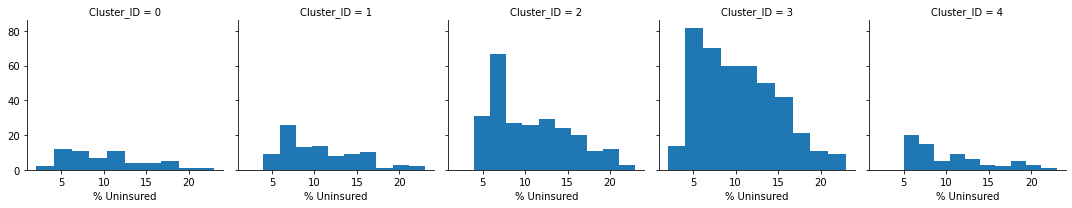

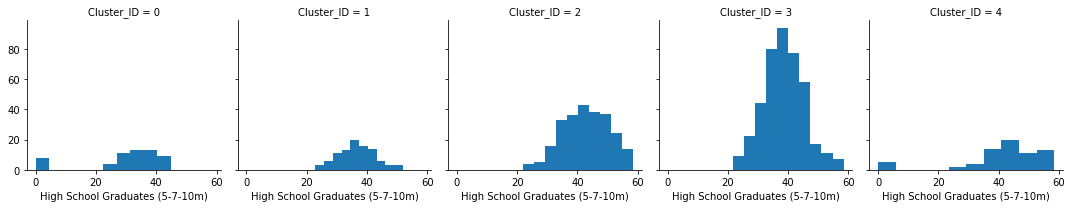

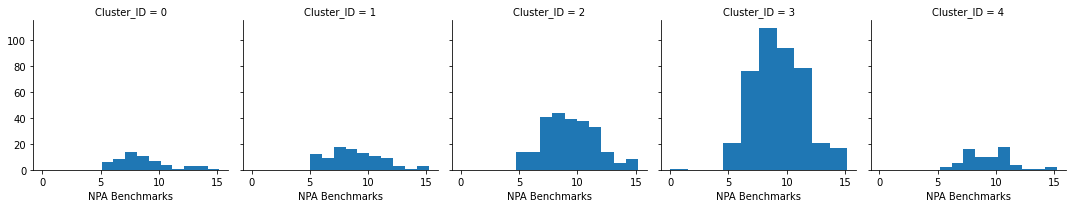

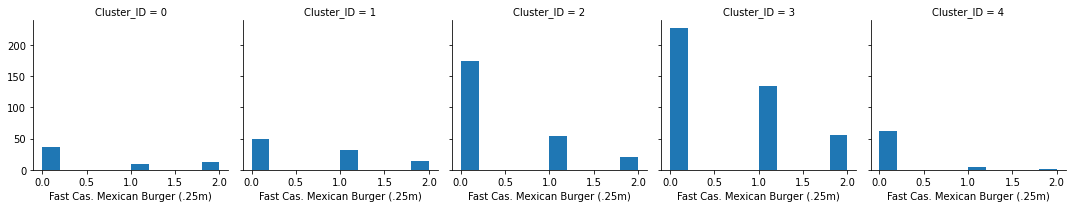

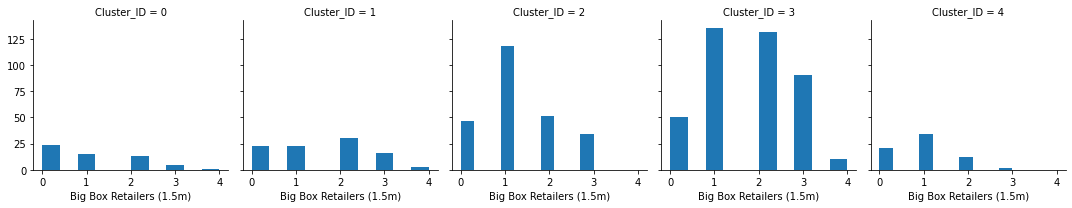

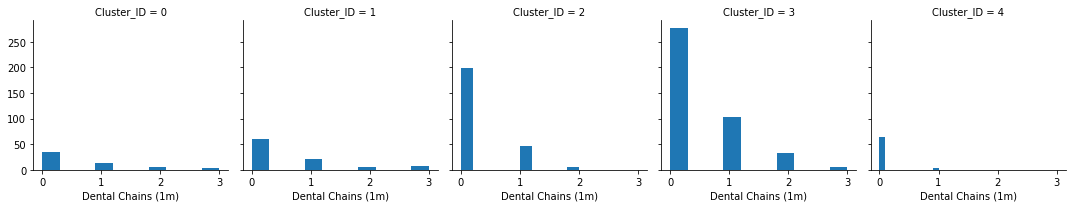

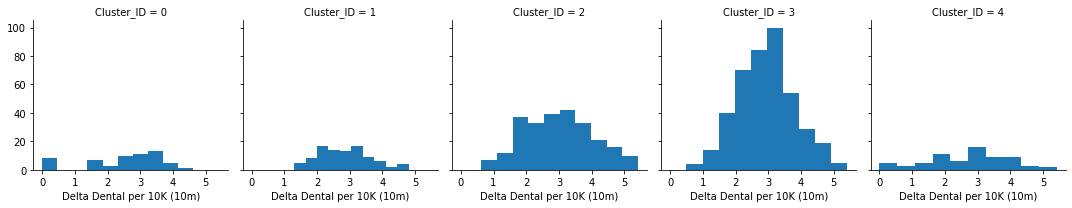

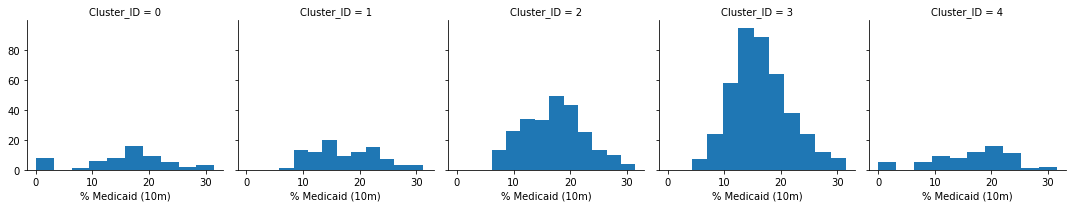

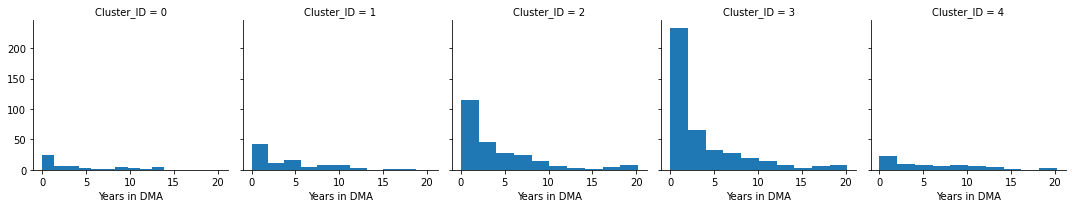

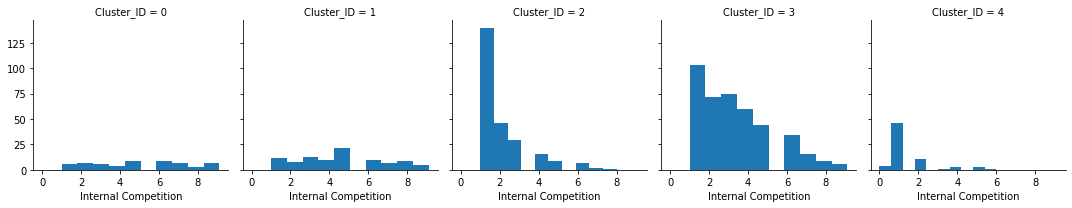

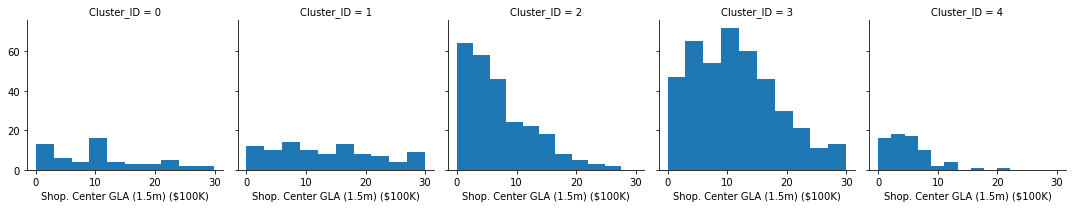

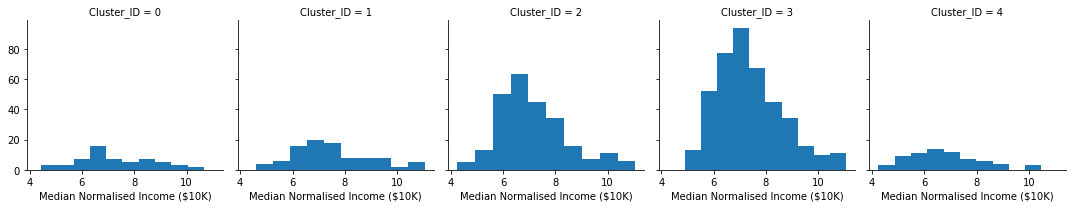

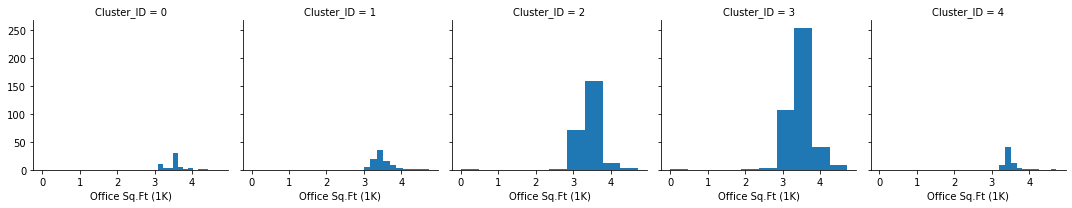

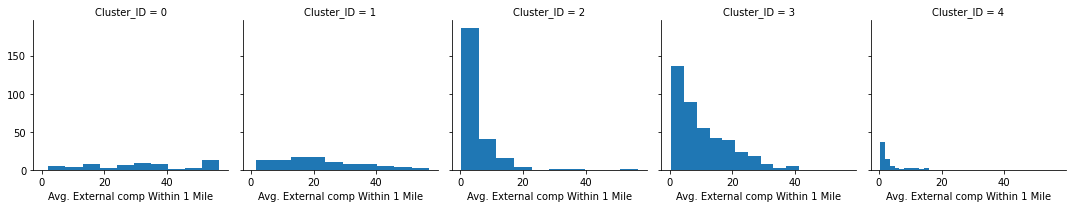

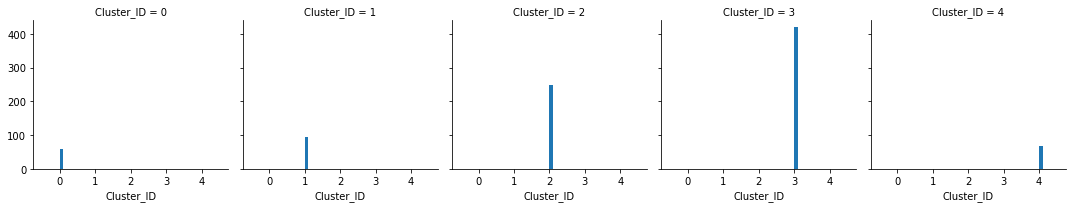

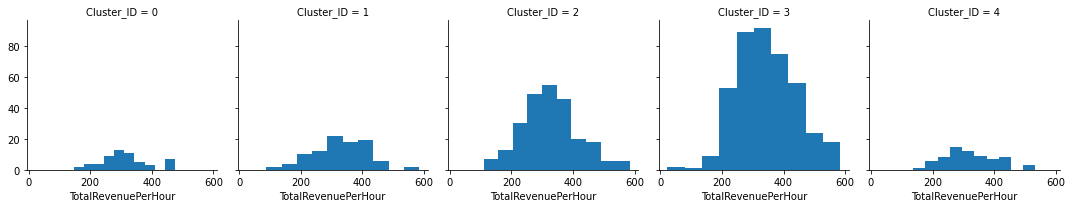

In [20]:
# sns.pairplot(df_scaled_clusters, hue='Cluster_ID', palette='dark')
for c in df_scaled_clusters:
    grid = sns.FacetGrid(df_scaled_clusters, col='Cluster_ID')
    grid.map(plt.hist, c)

### PCA

In [21]:
pca = PCA(n_components=6)
principalComponents = pca.fit_transform(df.select_dtypes(exclude='object'))
var = pca.explained_variance_ratio_

# Cumulative Explained Variance
cum_explained_var = []
for i in range(0, len(pca.explained_variance_ratio_)):
    if i == 0:
        cum_explained_var.append(pca.explained_variance_ratio_[i])
    else:
        cum_explained_var.append(pca.explained_variance_ratio_[i] + 
                                 cum_explained_var[i-1])

print(cum_explained_var)

[0.2993834822356068, 0.5225919176584406, 0.6938782029260065, 0.792836493921333, 0.868147560344373, 0.9090030350354124]


In [22]:
#Principal Components converted to a Data frame
principalDf  = pd.DataFrame(data = principalComponents, columns = ['PCA-1', 'PCA-2', 'PCA-3', 'PCA-4', 'PCA-5', 'PCA-6'])

In [23]:
#Concatenating the PCAs with the categorical variable
finalDf_Cat = pd.concat([principalDf, df['Office Class']], axis = 1)
finalDf_Cat

,PCA-1,PCA-2,PCA-3,PCA-4,PCA-5,PCA-6,Office Class
0,14.730115,-2.606221,4.685346,-12.631023,-4.312226,12.933930,Suburban
1,2.447171,-8.909098,5.296207,-9.197133,1.507081,14.084455,Suburban
2,-5.199758,-6.798935,-4.928668,-14.654457,4.774226,11.129173,Urban
3,13.623908,-4.315777,-0.159373,1.936489,8.330753,15.033092,Most Urban
4,11.977436,-9.373651,-10.838546,3.931060,8.080855,8.423973,Suburban
...,...,...,...,...,...,...,...
886,-0.729223,-3.898103,2.717541,0.023922,1.203719,3.881279,Rural
887,-9.275683,-0.411769,-2.125808,2.002825,5.882501,2.125093,Rural
888,46.892151,-19.739240,8.832284,-13.197743,11.808066,1.978531,Most Urban
889,-1.434217,-1.743436,5.373276,-2.880632,-5.374626,3.291403,Suburban


In [24]:
# Convert dataframe to matrix
X = finalDf_Cat.to_numpy()

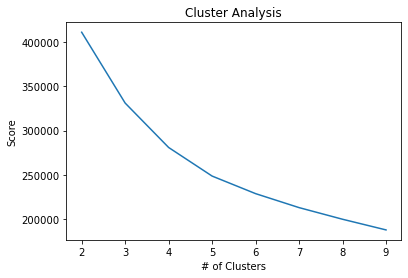

,# of Clusters,silhouette_score
0,2,0.31
1,3,0.30
2,4,0.31
3,5,0.21
4,6,0.21
5,7,0.20
6,8,0.20
7,9,0.21


In [25]:
#Choosing optimal K value
cost = []
scores = []

for cluster in range(2,10):
    kproto = KPrototypes(n_clusters=cluster, init='Huang', random_state=42, n_jobs=-2, n_init=50) 
    kproto.fit_predict(X, categorical=[6])
    cost.append(kproto.cost_)
    scores.append(silhouette_score(X[:,:-1], kproto.labels_))
    
sns.lineplot(range(2,10), cost)
plt.xlabel("# of Clusters")
plt.ylabel("Score")
plt.title("Cluster Analysis")
plt.show()

# Silhouette scores for different k values
table = pd.DataFrame({'# of Clusters':range(2,10), 'silhouette_score':['%.2f' % x for x in scores]})
table

In [26]:
# Running K-Prototype clustering
kproto = KPrototypes(n_clusters=5, init='Huang', verbose=0, random_state=42,max_iter=20, n_init=50,n_jobs=-2,gamma=.25) 
clusters = kproto.fit_predict(X, categorical=[6])

In [27]:
df_clusters_pca = df.copy()
df_clusters_pca['Cluster_ID'] = clusters
df_clusters_pca['TotalRevenuePerHour'] = data['TotalRevenuePerHour']
df_clusters_pca['Cluster_ID'].value_counts()

4    301
3    296
1    143
0    103
2     48
Name: Cluster_ID, dtype: int64

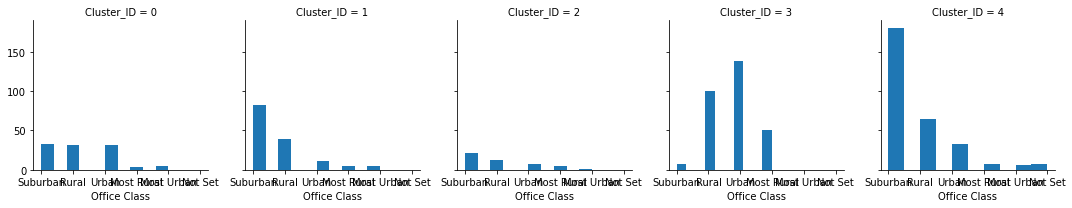

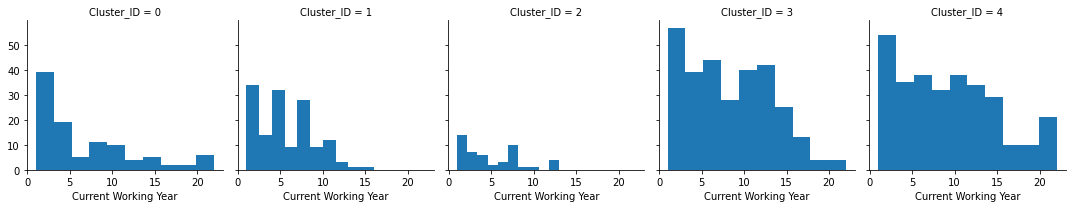

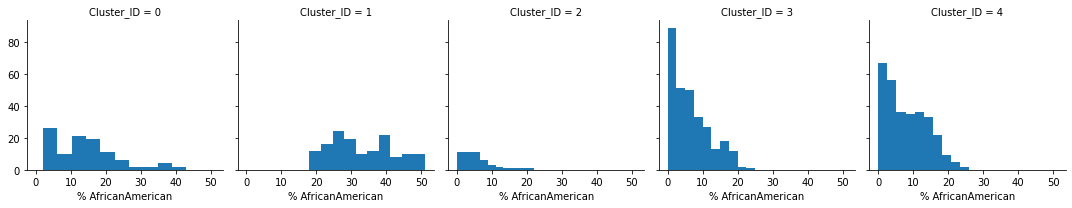

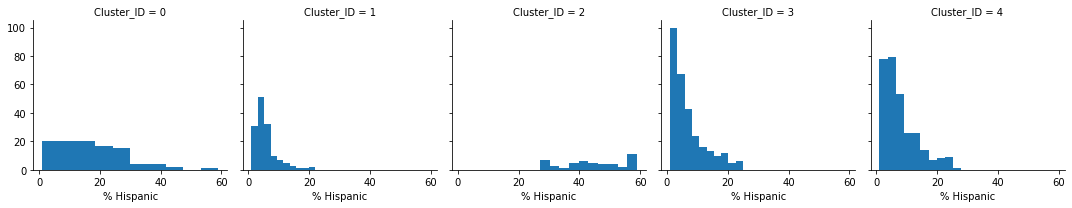

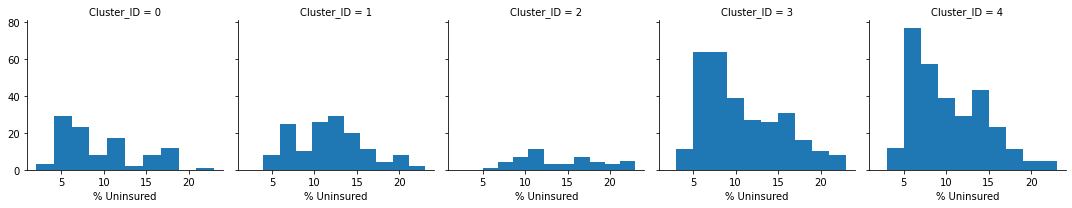

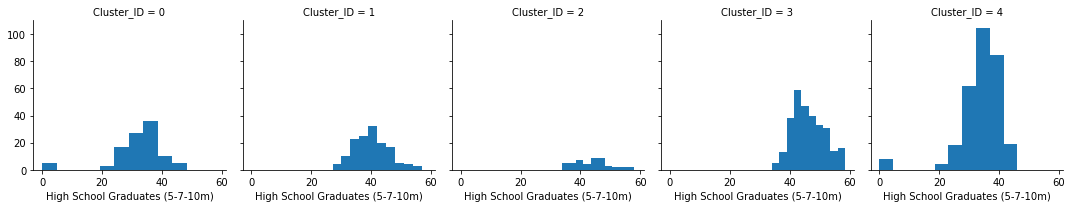

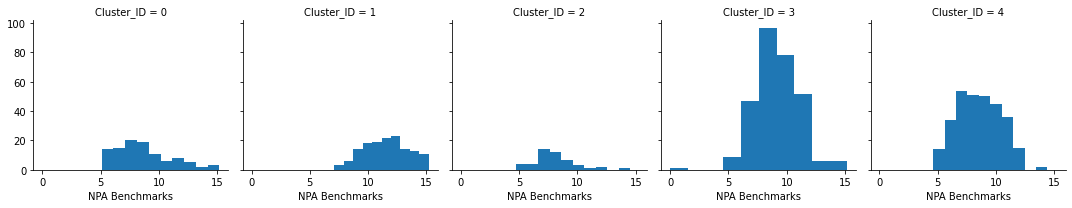

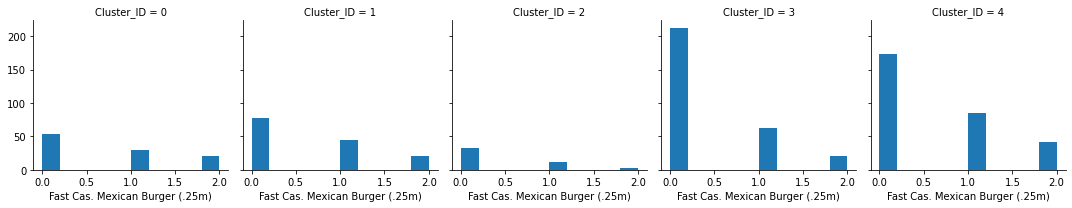

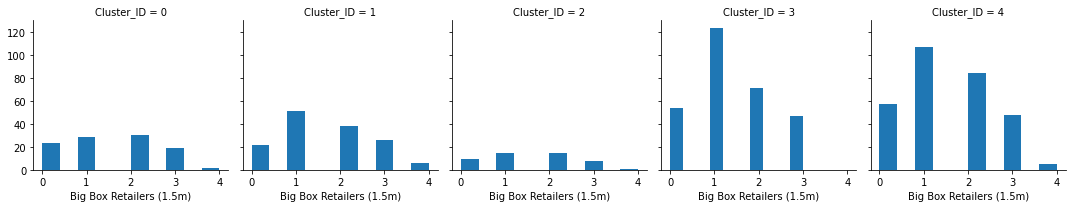

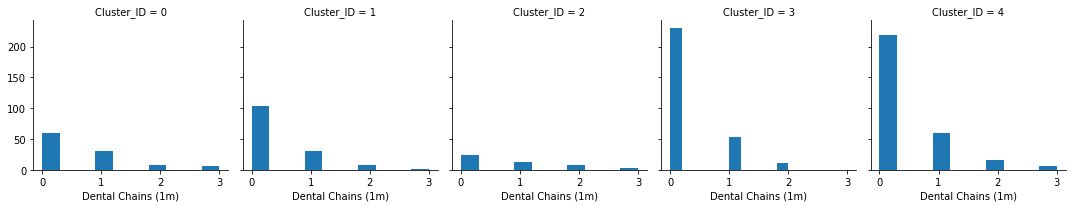

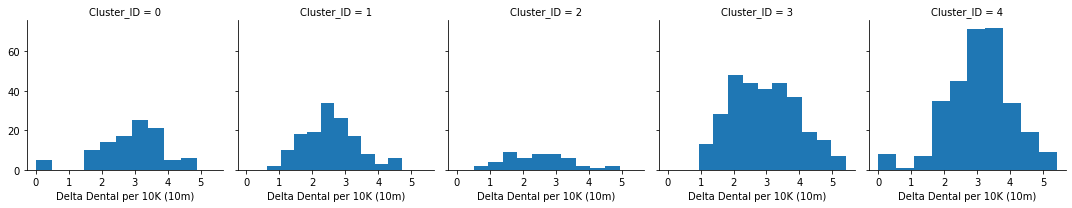

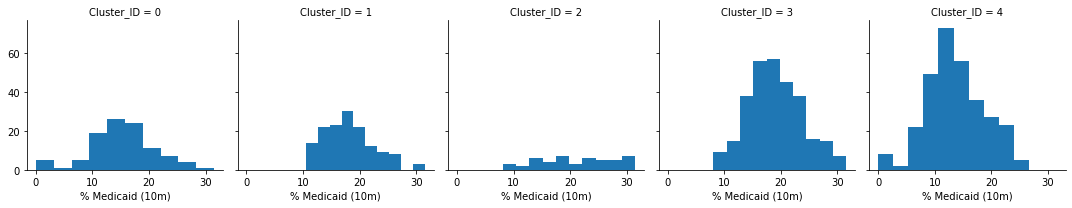

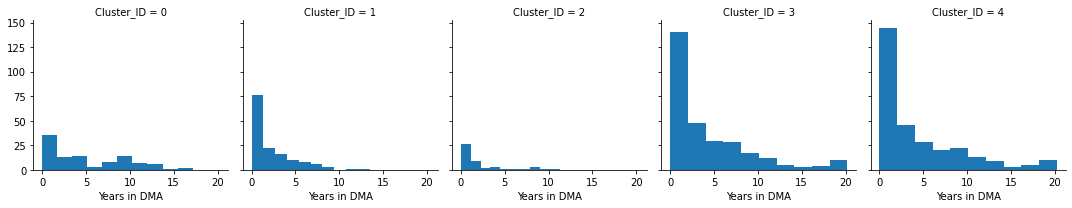

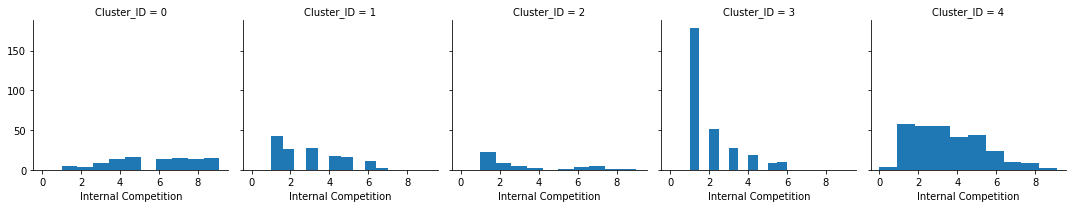

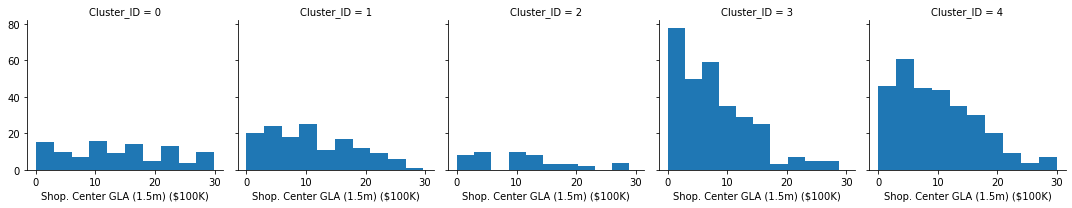

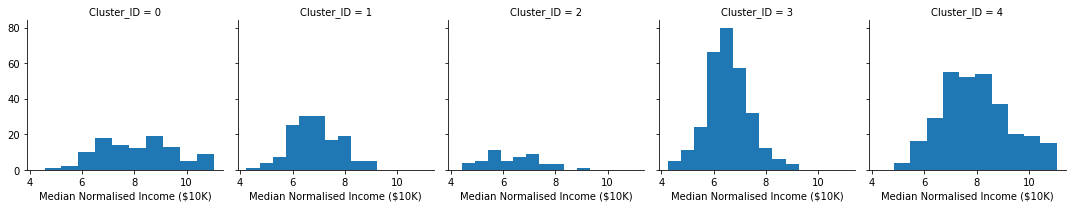

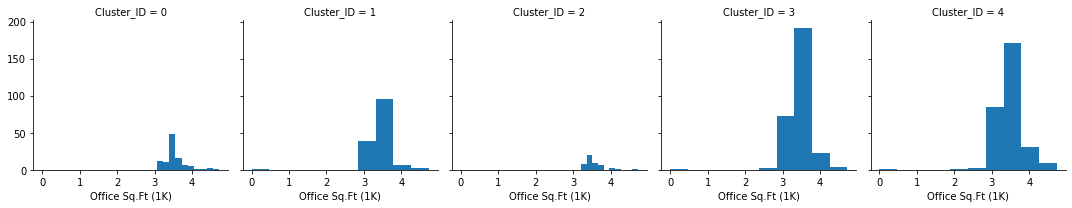

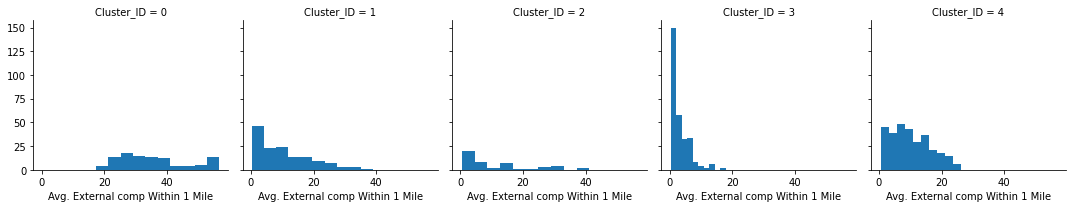

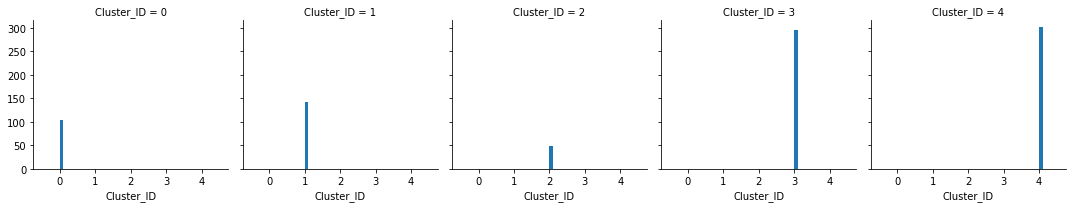

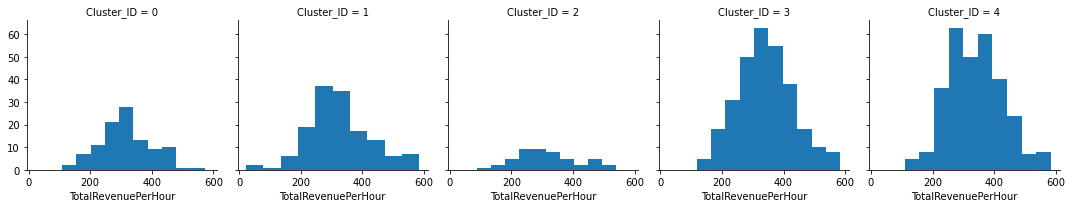

In [28]:
# sns.pairplot(df_clusters_pca, hue='Cluster_ID', palette='Dark2', diag_kind='kde')
for c in df_clusters_pca:
    grid = sns.FacetGrid(df_clusters_pca, col='Cluster_ID')
    grid.map(plt.hist, c)

In [29]:
final_data = df_clusters_pca.copy()
final_data

,Office Class,Current Working Year,% AfricanAmerican,% Hispanic,% Uninsured,High School Graduates (5-7-10m),NPA Benchmarks,Fast Cas. Mexican Burger (.25m),Big Box Retailers (1.5m),Dental Chains (1m),Delta Dental per 10K (10m),% Medicaid (10m),Years in DMA,Internal Competition,Shop. Center GLA (1.5m) ($100K),Median Normalised Income ($10K),Office Sq.Ft (1K),Avg. External comp Within 1 Mile,Cluster_ID,TotalRevenuePerHour
0,Suburban,22.0,15.0,20.0,5.0,38.5,7.7,0.0,1.0,0.0,3.840141,21.9,0.000000,7.0,17.81,7.650,3.75,23.15,0,310.0
1,Suburban,22.0,7.0,18.0,4.0,43.5,7.5,0.0,3.0,0.0,1.854511,22.2,0.000000,7.0,8.96,6.670,4.00,14.65,4,388.0
2,Urban,22.0,2.0,4.0,4.0,44.3,6.8,1.0,0.0,0.0,2.590615,21.9,0.000000,6.0,9.35,7.260,3.95,14.45,3,403.0
3,Most Urban,22.0,15.0,19.0,12.0,33.1,5.1,0.0,0.0,0.0,3.742308,19.5,9.438356,4.0,0.00,9.340,3.69,22.60,0,309.0
4,Suburban,19.0,7.0,14.0,12.0,30.2,4.6,0.0,0.0,0.0,4.125406,9.9,11.652055,3.0,0.00,11.061,3.14,23.55,4,384.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,Rural,10.0,10.0,14.0,7.0,41.2,8.6,0.0,1.0,1.0,1.625645,17.6,2.301370,4.0,7.38,7.960,3.20,10.00,4,374.0
887,Rural,10.0,9.0,4.0,14.0,42.1,7.4,0.0,0.0,0.0,3.912135,17.4,0.882192,2.0,1.82,7.900,3.20,6.25,3,248.0
888,Most Urban,10.0,6.0,38.0,12.0,38.2,6.7,2.0,2.0,1.0,3.156912,23.7,2.953425,9.0,11.80,6.160,3.35,56.74,0,335.0
889,Suburban,10.0,12.0,15.0,6.0,40.8,10.4,0.0,1.0,0.0,1.955790,20.1,2.665753,4.0,14.69,7.140,3.30,6.90,4,277.0


In [31]:
final_data.groupby('Cluster_ID').agg(
    {
        'Office Class': lambda x: x.value_counts().index[0],
        'Current Working Year' : 'mean',
        '% AfricanAmerican' : 'mean',
        '% Hispanic' : 'mean',
        '% Uninsured' : 'mean',
        'Median Normalised Income ($10K)' : 'mean',
        'Avg. External comp Within 1 Mile' : 'count',
        'High School Graduates (5-7-10m)' : 'mean',
        'NPA Benchmarks' : 'mean',
        'Fast Cas. Mexican Burger (.25m)' : 'count',
        'Shop. Center GLA (1.5m) ($100K)' : 'mean',
        'Big Box Retailers (1.5m)' : 'count',
        'Dental Chains (1m)' : 'count',
        'Delta Dental per 10K (10m)' : 'count',
        '% Medicaid (10m)' : 'mean',
        'Years in DMA' : 'mean',
        'Office Sq.Ft (1K)' : 'mean',
        'Internal Competition' : 'count',
        'TotalRevenuePerHour' : 'sum'
    }
).reset_index()

,Cluster_ID,Office Class,Current Working Year,% AfricanAmerican,% Hispanic,% Uninsured,Median Normalised Income ($10K),Avg. External comp Within 1 Mile,High School Graduates (5-7-10m),NPA Benchmarks,Fast Cas. Mexican Burger (.25m),Shop. Center GLA (1.5m) ($100K),Big Box Retailers (1.5m),Dental Chains (1m),Delta Dental per 10K (10m),% Medicaid (10m),Years in DMA,Office Sq.Ft (1K),Internal Competition,TotalRevenuePerHour
0,0,Suburban,6.834951,14.417476,16.796117,9.650485,8.164592,103,32.140777,8.708738,103,13.800262,103,103,103,15.164078,5.120654,3.546000,103,32692.0
1,1,Suburban,5.412587,33.055944,5.951049,11.622378,6.879371,143,40.151748,11.576923,143,11.047552,143,143,143,18.076434,2.151969,3.447119,143,46324.0
2,2,Suburban,5.062500,5.916667,44.500000,14.062500,6.367708,48,43.904167,7.997917,48,10.563750,48,48,48,21.303125,2.107477,3.570375,48,15082.0
3,3,Rural,8.459459,6.513514,6.777027,10.324324,6.549291,296,46.274493,9.175676,296,7.829155,296,296,296,19.112804,4.117271,3.470601,296,100790.6
4,4,Suburban,9.368771,8.053156,7.830565,9.747508,7.994671,301,33.701993,8.517940,301,9.878711,301,301,301,13.719269,4.282042,3.488173,301,102026.2


In [ ]:
# cluster_0 = final_data[final_data['Cluster_ID']==0]
# cluster_1 = final_data[final_data['Cluster_ID']==1]
# cluster_2 = final_data[final_data['Cluster_ID']==2]
# cluster_3 = final_data[final_data['Cluster_ID']==3]

In [ ]:
# # importing sweetviz
# import sweetviz as sv
# #analyzing the dataset
# report_0 = sv.analyze(cluster_0)
# report_1 = sv.analyze(cluster_1)
# report_2 = sv.analyze(cluster_2)
# report_3 = sv.analyze(cluster_3)
# #display the report
# report_0.show_html('Cluster_0.html')
# report_1.show_html('Cluster_1.html')
# report_2.show_html('Cluster_2.html')
# report_3.show_html('Cluster_3.html')

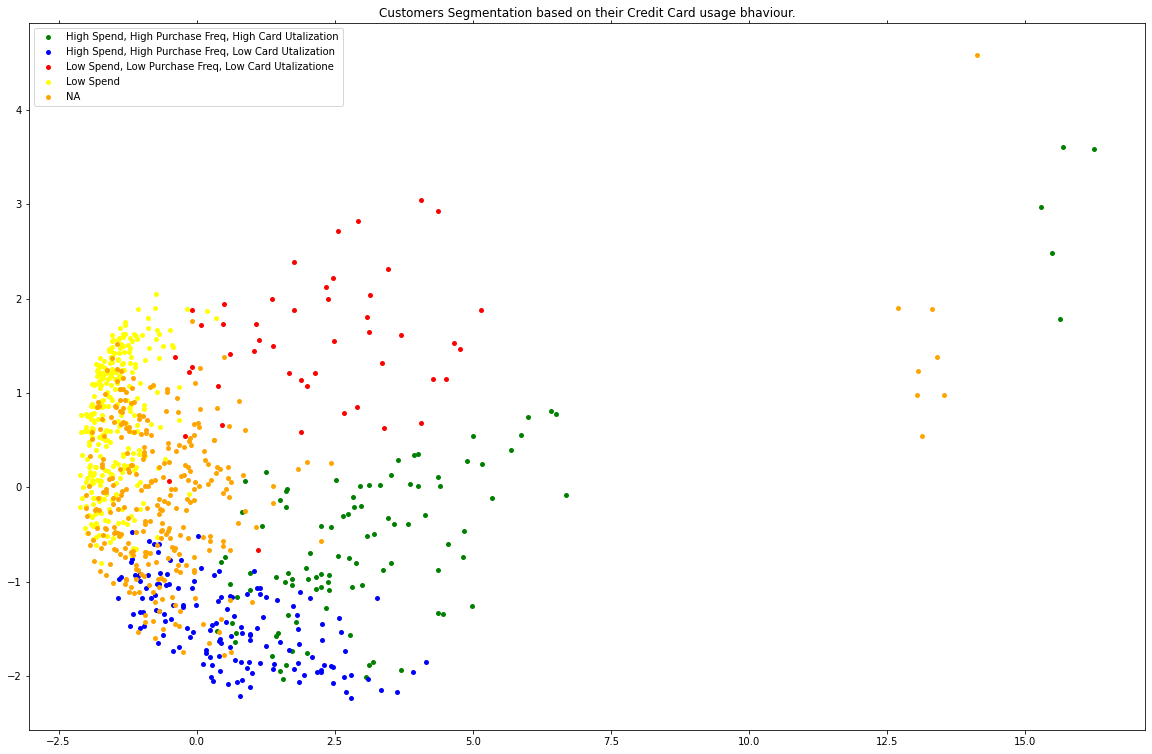

In [32]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(df.iloc[:,1:])
pca = PCA(2)
pca.fit(dist)
X_PCA = pca.transform(dist)

 

x, y = X_PCA[:, 0], X_PCA[:, 1]

 

colors = {0: 'green',
          1: 'blue',
          2: 'red',
          3: 'yellow',
          4: 'orange'}

 

names = {0: 'High Spend, High Purchase Freq, High Card Utalization', 
         1: 'High Spend, High Purchase Freq, Low Card Utalization', 
         2: 'Low Spend, Low Purchase Freq, Low Card Utalizatione',
         3: 'Low Spend',
         4: 'NA'}
  
df = pd.DataFrame({'x': x, 'y':y, 'label':clusters}) 
groups = df.groupby('label')

 

fig, ax = plt.subplots(figsize=(20, 13)) 

 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name],label=names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
    
ax.legend()
ax.set_title("Customers Segmentation based on their Credit Card usage bhaviour.")
plt.show()